<a href="https://colab.research.google.com/github/amanteur/VK_Network_Science_Project/blob/main/VK_project_4_Community_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VK Project
### Network Science, Amantur Amatov


In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap

In [ ]:
g = nx.read_gexf('friend_list.gexf')
largest_component = max(nx.connected_components(g), key=len)
lc = g.subgraph(largest_component).copy()

In [ ]:
def my_colormap(name_cmap, alpha):
  cmap = plt.get_cmap(name_cmap)
  my_cmap = cmap(np.arange(cmap.N))
  my_cmap[:,-1] = np.linspace(alpha, 1, cmap.N)
  my_cmap = ListedColormap(my_cmap)
  return my_cmap
def pos_layout(g):
  df = pd.DataFrame(index=g.nodes(), columns=g.nodes())
  for row, data in nx.shortest_path_length(g):
      for col, dist in data.items():
          df.loc[row,col] = dist

  df = df.fillna(df.max().max())
  return df
df_g = pos_layout(g)
pos = nx.kamada_kawai_layout(g, dist=df_g.to_dict())

#### Clique search, k-cores visualization and interpretation.

Clique Search

In [ ]:
print('Number of cliques in social network is {}.'.format(nx.graph_number_of_cliques(g)))

Number of cliques in social network is 803.


In [ ]:
print('The clique number is {}.'.format(nx.graph_clique_number(g)))

The clique number is 11.


In [ ]:
print('Average size of clique in graph is {:.3f}.'.format(np.array([len(clq) for clq in nx.find_cliques(g)]).mean()))

Average size of clique in graph is 5.822.


In [ ]:
#max cliques
def find_max_cliques(g):
  cliques = sorted(list(nx.find_cliques(g)), key = len, reverse=True)
  max_size = len(cliques[0])
  max_cliques = [clique for clique in cliques if len(clique)==max_size]
  node_colors = [['yellow' if node in max_clique else 'tab:purple'
                  for node in g.nodes] 
                    for max_clique in max_cliques]
  return max_cliques, node_colors

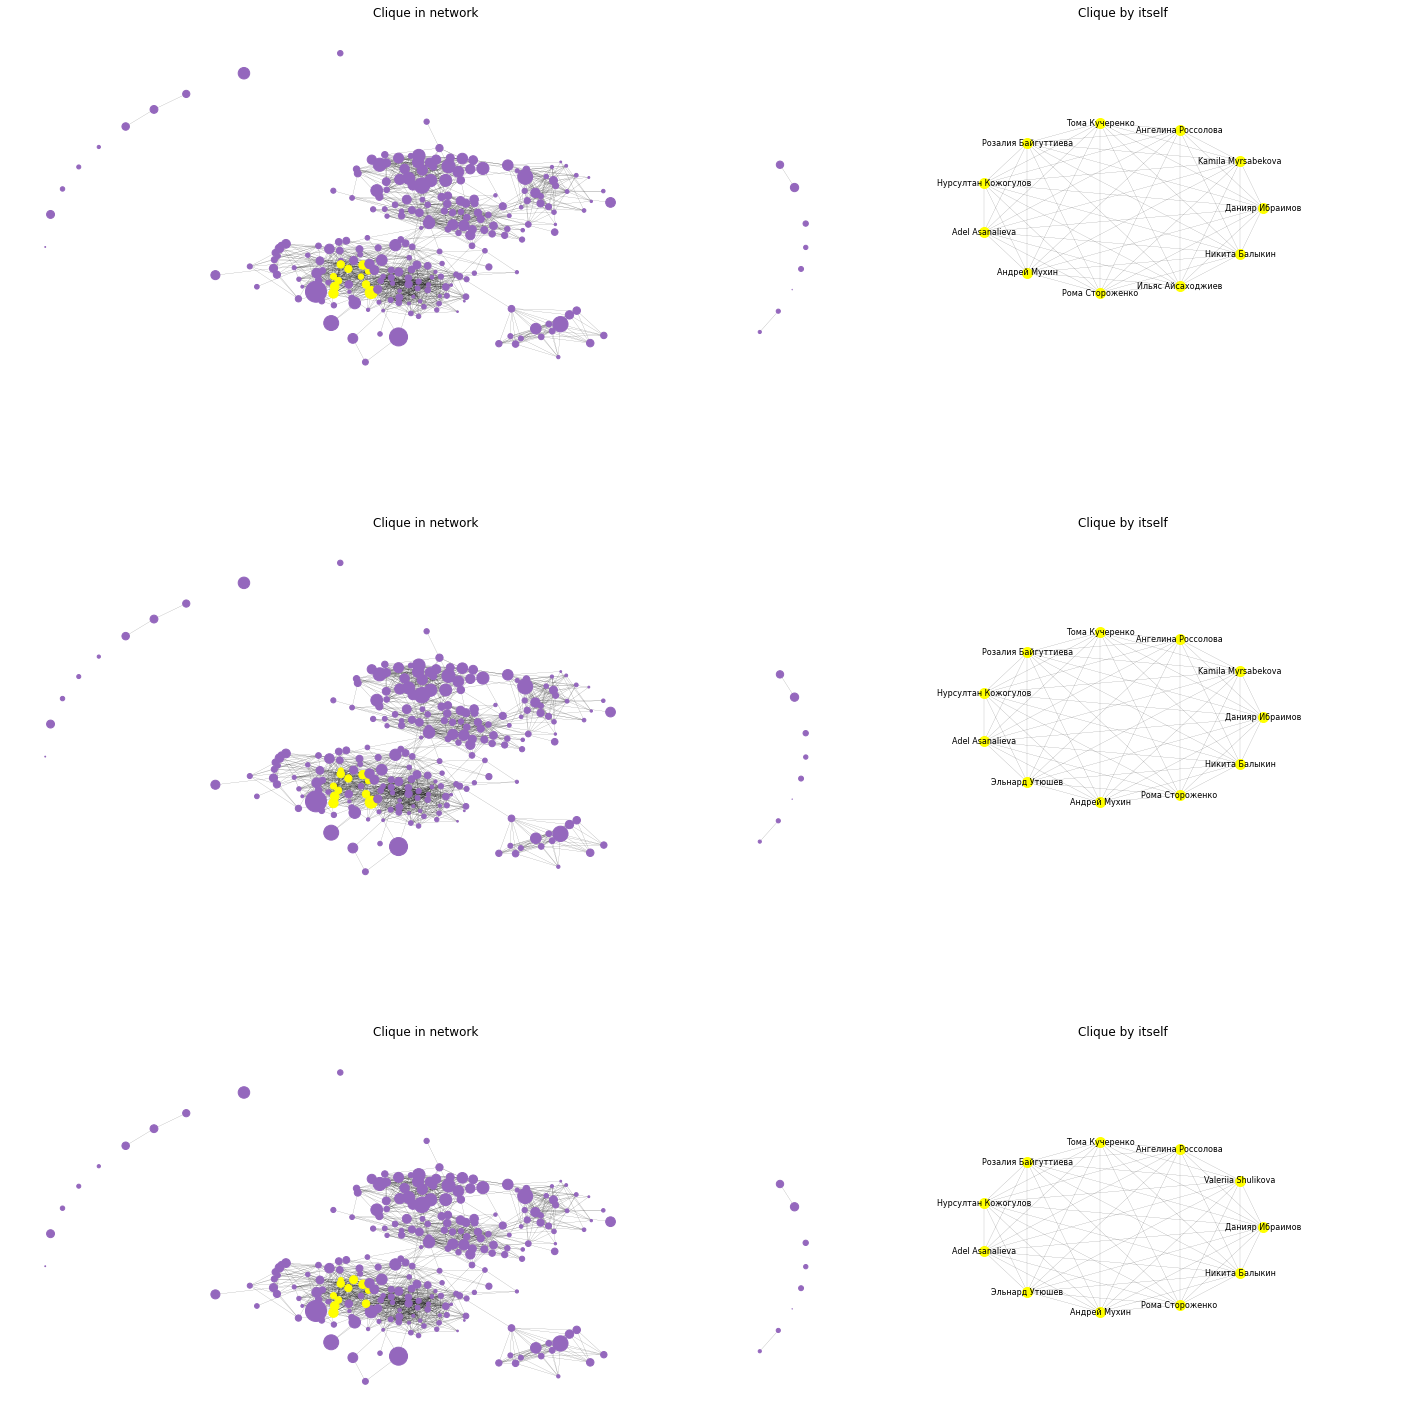

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(25,25), gridspec_kw={'width_ratios': [3, 2]})
fig.subplots_adjust(hspace=.5, wspace=.001)
axe = axes.ravel()
fig.subplots_adjust(hspace = .5)


max_cliques, node_colors = find_max_cliques(g)
node_size = [val["nfriends"]/5 for key, val in g.nodes().items()]


for max_clique, node_color,i in zip(max_cliques, node_colors,range(0,len(axe),2)):
  nodes_name = {node:g.nodes()[node]['name'] for node in max_clique}
  axe[i].set_title('Clique in network\n')
  nx.draw(g, 
        node_color=node_color, 
        pos=pos,
        width = 0.1,
        node_size=node_size,
        ax=axe[i])
  axe[i+1].set_title('Clique by itself\n')
  axe[i+1].margins(0.5)
  clique = g.subgraph(max_clique).copy()
  nx.draw(clique, 
        node_color='yellow', 
        pos=nx.kamada_kawai_layout(clique),
        width = 0.1,
        node_size=100,
        ax=axe[i+1])
  nx.draw_networkx_labels(clique,
                          pos=nx.kamada_kawai_layout(clique),
                          labels=nodes_name,
                          ax=axe[i+1],
                          font_size=8)
  

They are all my friends from school. Better to say we all were in one group who took Olympiad exams.

k-core decomposition

In [ ]:
def k_core_decompose(G):
  return np.array(list(nx.core_number(G).values()))

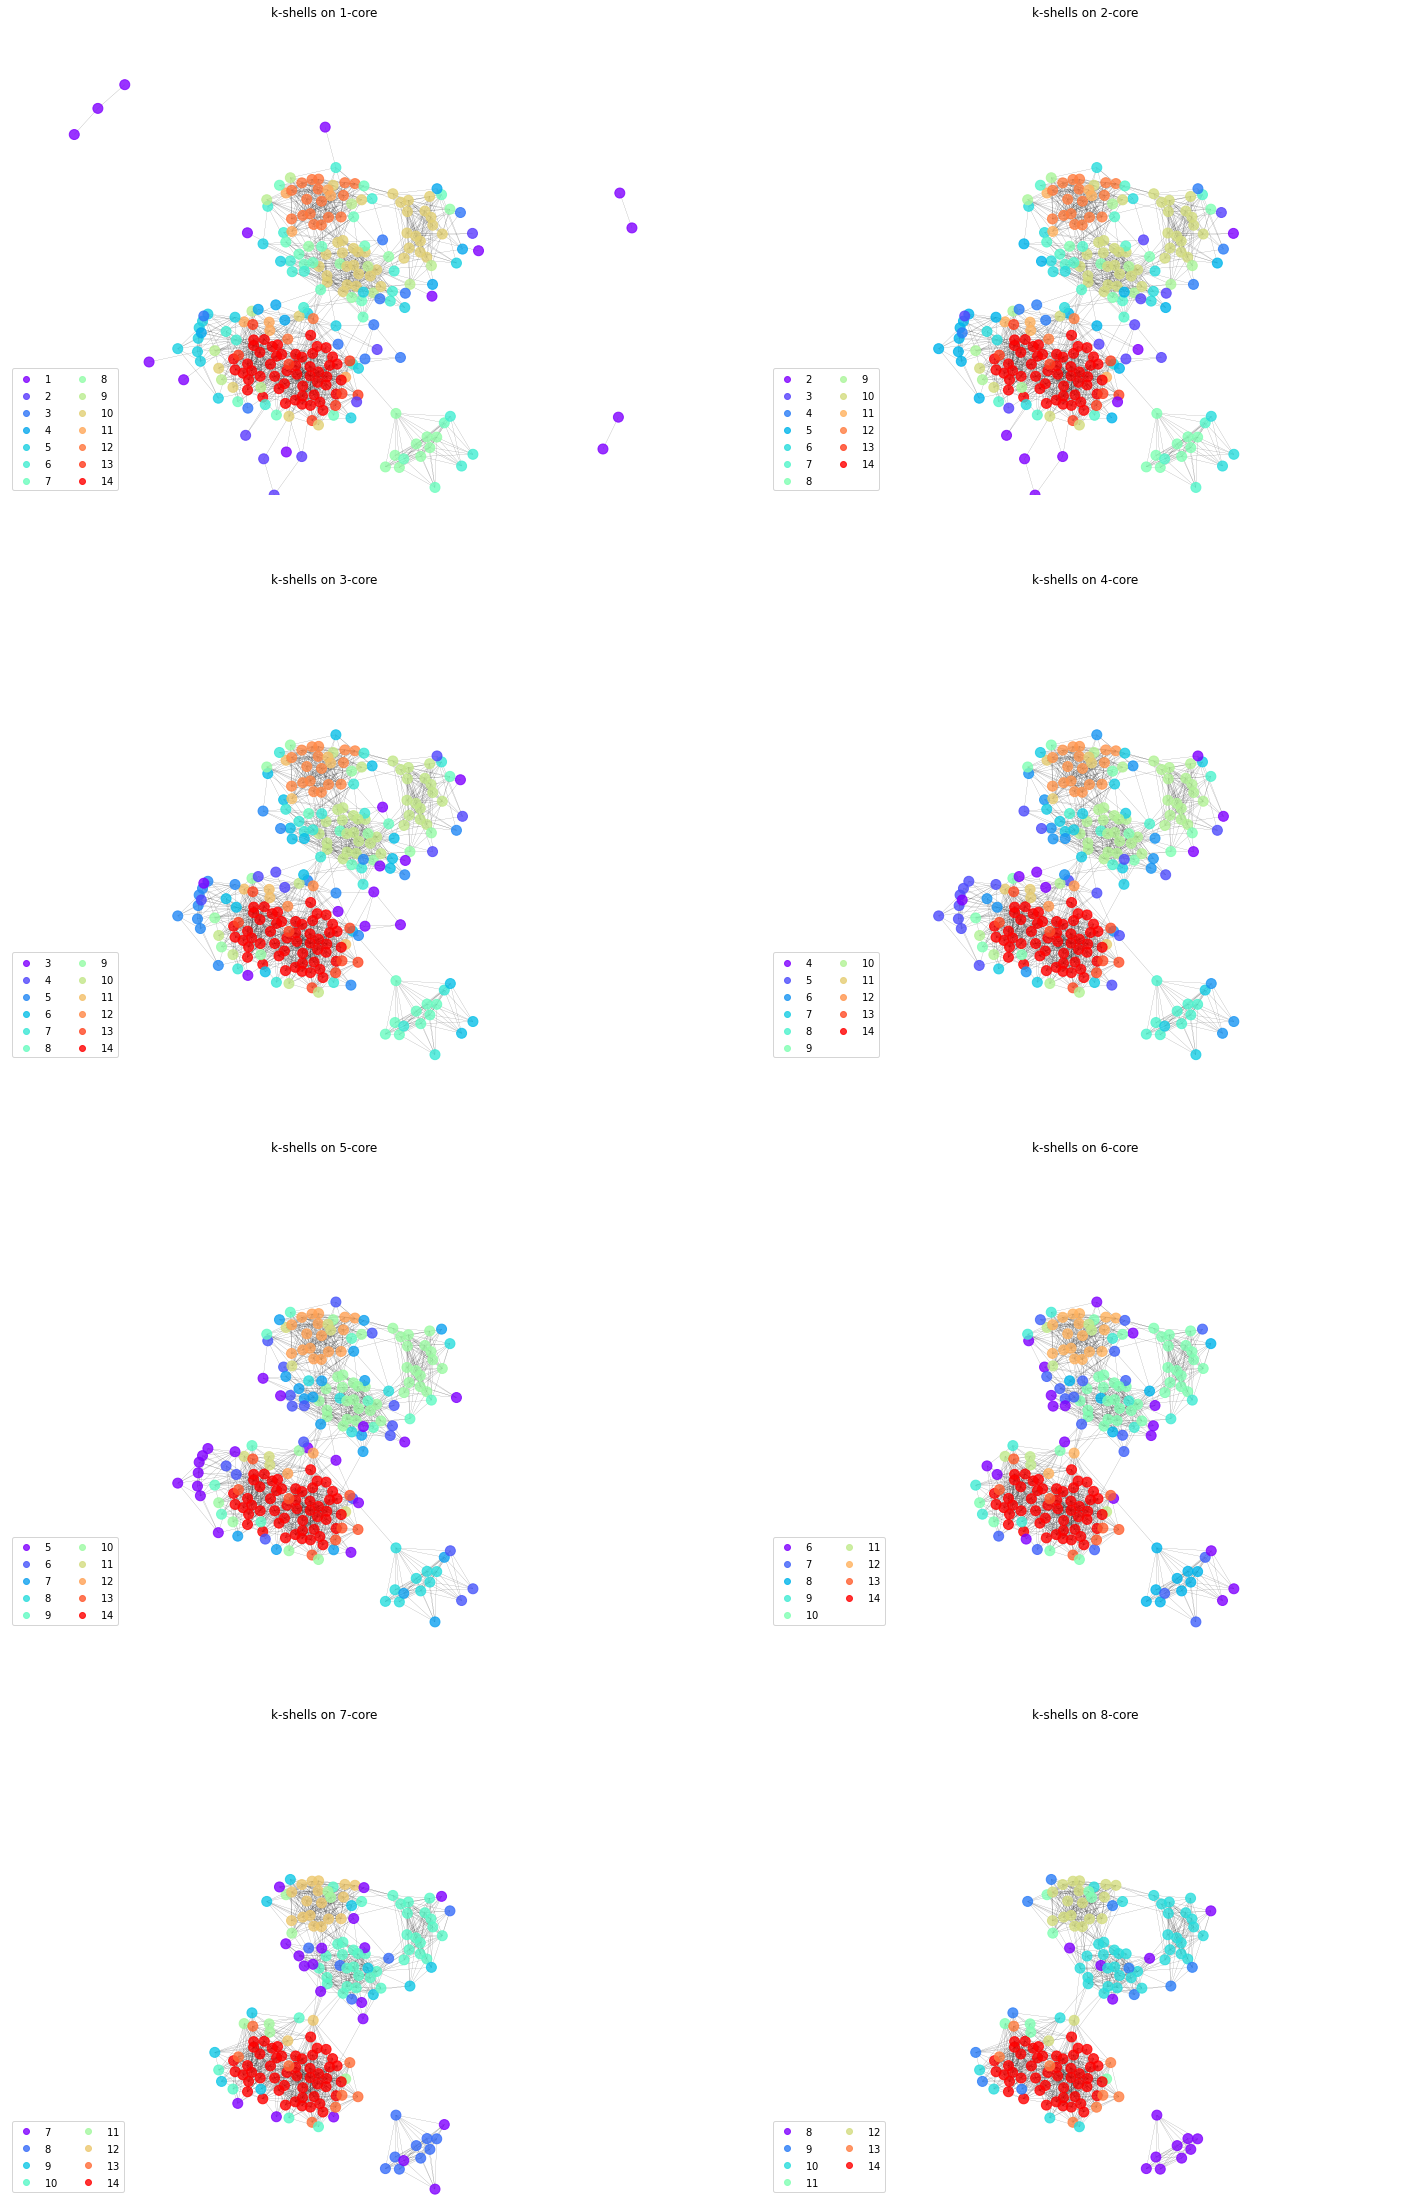

In [ ]:
my_cmap = my_colormap('plasma', 0.4)
plt.figure(figsize=(25, 40))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

for i in range(8):
    plt.subplot(4, 2, i+1)
    subG = nx.k_core(g, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        pos=pos,
        cmap=plt.get_cmap('rainbow'),
        node_color=k_core_decompose(subG), 
        node_size=100,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        subG, 
        pos=pos,
        width=0.1
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(*nodes.legend_elements(), loc="lower left", ncol=len(nodes.legend_elements()))
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

Gephi style of making communities based on modularity score.

![](https://drive.google.com/uc?export=view&id=1eRyMb6XgYQgJ289FyjC5sYd9Ump5m9R2)

#### Another types of communities detection algorithms

In [ ]:
from networkx.algorithms import community as com
lc_nodes =sorted([list(cc) for cc in nx.connected_components(g)], key=len, reverse=True)[0]
lc = g.subgraph(lc_nodes).copy()

Finding communities in graph using Clauset-Newman-Moore greedy modularity maximization. 

In [ ]:
def gmc(g):
  c = [set(com) for com in com.greedy_modularity_communities(g)]
  partition = {node:c.index(com) for com in c for node in com }
  return c, partition


Finding communities in a graph using the Girvan–Newman method

In [ ]:
from itertools import takewhile
def gn(g, k):
  comp = com.girvan_newman(g)
  limited = takewhile(lambda c: len(c) <= k, comp)
  for communities in limited:
    coms = list(sorted(c) for c in communities)
  partition = {node:coms.index(com) for com in coms for node in com }
  return coms, partition

Finding communities via Fluid Communities algorithm

In [ ]:
def fc(g, k):
  c = [set(com) for com in com.asyn_fluidc(g, k)]
  partition = {node:c.index(com) for com in c for node in com }
  return c, partition

Finding communities by asynchronous label propagation

In [ ]:
def alp(g):
  c = [set(com) for com in com.asyn_lpa_communities(g)]
  partition = {node:c.index(com) for com in c for node in com }
  return c, partition

Louvain method

In [ ]:
!pip install python-louvain

In [ ]:
def lm(g):
  partition = community_louvain.best_partition(lc)
  unique_com = set(v for _,v in partition.items())
  coms = []
  for com in unique_com:
    com_list = set()
    for k,v in partition.items():
      if v == com:
        com_list.add(k)
    coms.append(com_list)
  return coms, partition

Laplacian Eigenmaps 

In [ ]:
from sklearn.cluster import KMeans

def norm_laplacian(A):
    G = nx.from_numpy_matrix(A)
    D = np.array(list(G.degree()))[:,1].astype(int)
    L = np.diag(D**(-1/2))@(np.diag(D) - A)@np.diag(D**(-1/2))
    return L, D
def spectral_embedding(L, degree_seq, n_components):
  vals, vecs = np.linalg.eigh(L)
  return (vecs*degree_seq.reshape((-1,1))**(-1/2))[:, 1:n_components+1]
def sc(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L, degree_seq = norm_laplacian(A)
    embedding = spectral_embedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    partition = dict(zip(G.nodes(), kmeans.labels_))
    unique_com = set(v for _,v in partition.items())
    coms = []
    for com in unique_com:
      com_list = set()
      for k,v in partition.items():
        if v == com:
          com_list.add(k)
      coms.append(com_list)
    return coms, partition

In [ ]:
from sklearn.metrics import silhouette_score

def silhouette_val(g, partitions):
  g_size = len(g.nodes)
  spl_array = np.zeros([g_size, g_size])
  labels = []
  for node_a, i in zip(g.nodes(), range(g_size)):
    labels.append(partitions[node_a])
    for node_b, j in zip(lc.nodes(), range(g_size)):
      spl_array[i,j] = nx.shortest_path_length(lc, node_a, node_b)

  ss = silhouette_score(spl_array, np.array(labels), metric='precomputed')
  return ss

Unified form for building network

In [ ]:
def show_graph_communities(g, com_alg_dict):
  number_alg = len(com_alg_dict)
  fig, axes = plt.subplots(number_alg//3,number_alg//2, figsize=(12*(number_alg//2),
                                                                 12*(number_alg//3)))
  axe = axes.ravel()
  score_dict ={}
  for com_alg,i in zip(com_alg_dict.items(), range(number_alg)):
    coms_list, coms = com_alg[1](lc)
    cmap = cm.get_cmap('rainbow', max(coms.values()) + 1)
    modularity = com.quality.modularity(lc, coms_list)
    coverage = com.quality.coverage(lc, coms_list)
    performance = com.quality.performance(lc, coms_list)
    silhouette = silhouette_val(lc, coms)
    score_dict[com_alg[0]] = {'modularity':modularity,
                              'coverage':coverage,
                              'performance':performance,
                              'silhouette': silhouette}

    axe[i].set_title('Algorithm - "{}"\n\n'.
                     format(com_alg[0])+
                     'Modularity = {:.4f}, '.format(modularity)+
                     'Coverage = {:.4f},\n '.format(coverage)+
                     'Performance = {:.4f}, '.format(performance)+
                     'Silhouette = {:.4f}'.format(silhouette))
    axe[i].axis('off')
    nodes = nx.draw_networkx_nodes(g,
                                  pos,
                                  coms.keys(),
                                  node_size=40,
                                  cmap=cmap, 
                                  node_color=list(coms.values()),
                                  ax=axe[i])
    nx.draw_networkx_edges(g, 
                           pos, 
                           width=0.1,
                           ax=axe[i])
    axe[i].legend(*nodes.legend_elements(), loc="lower left", ncol=len(nodes.legend_elements()))
  
  return score_dict

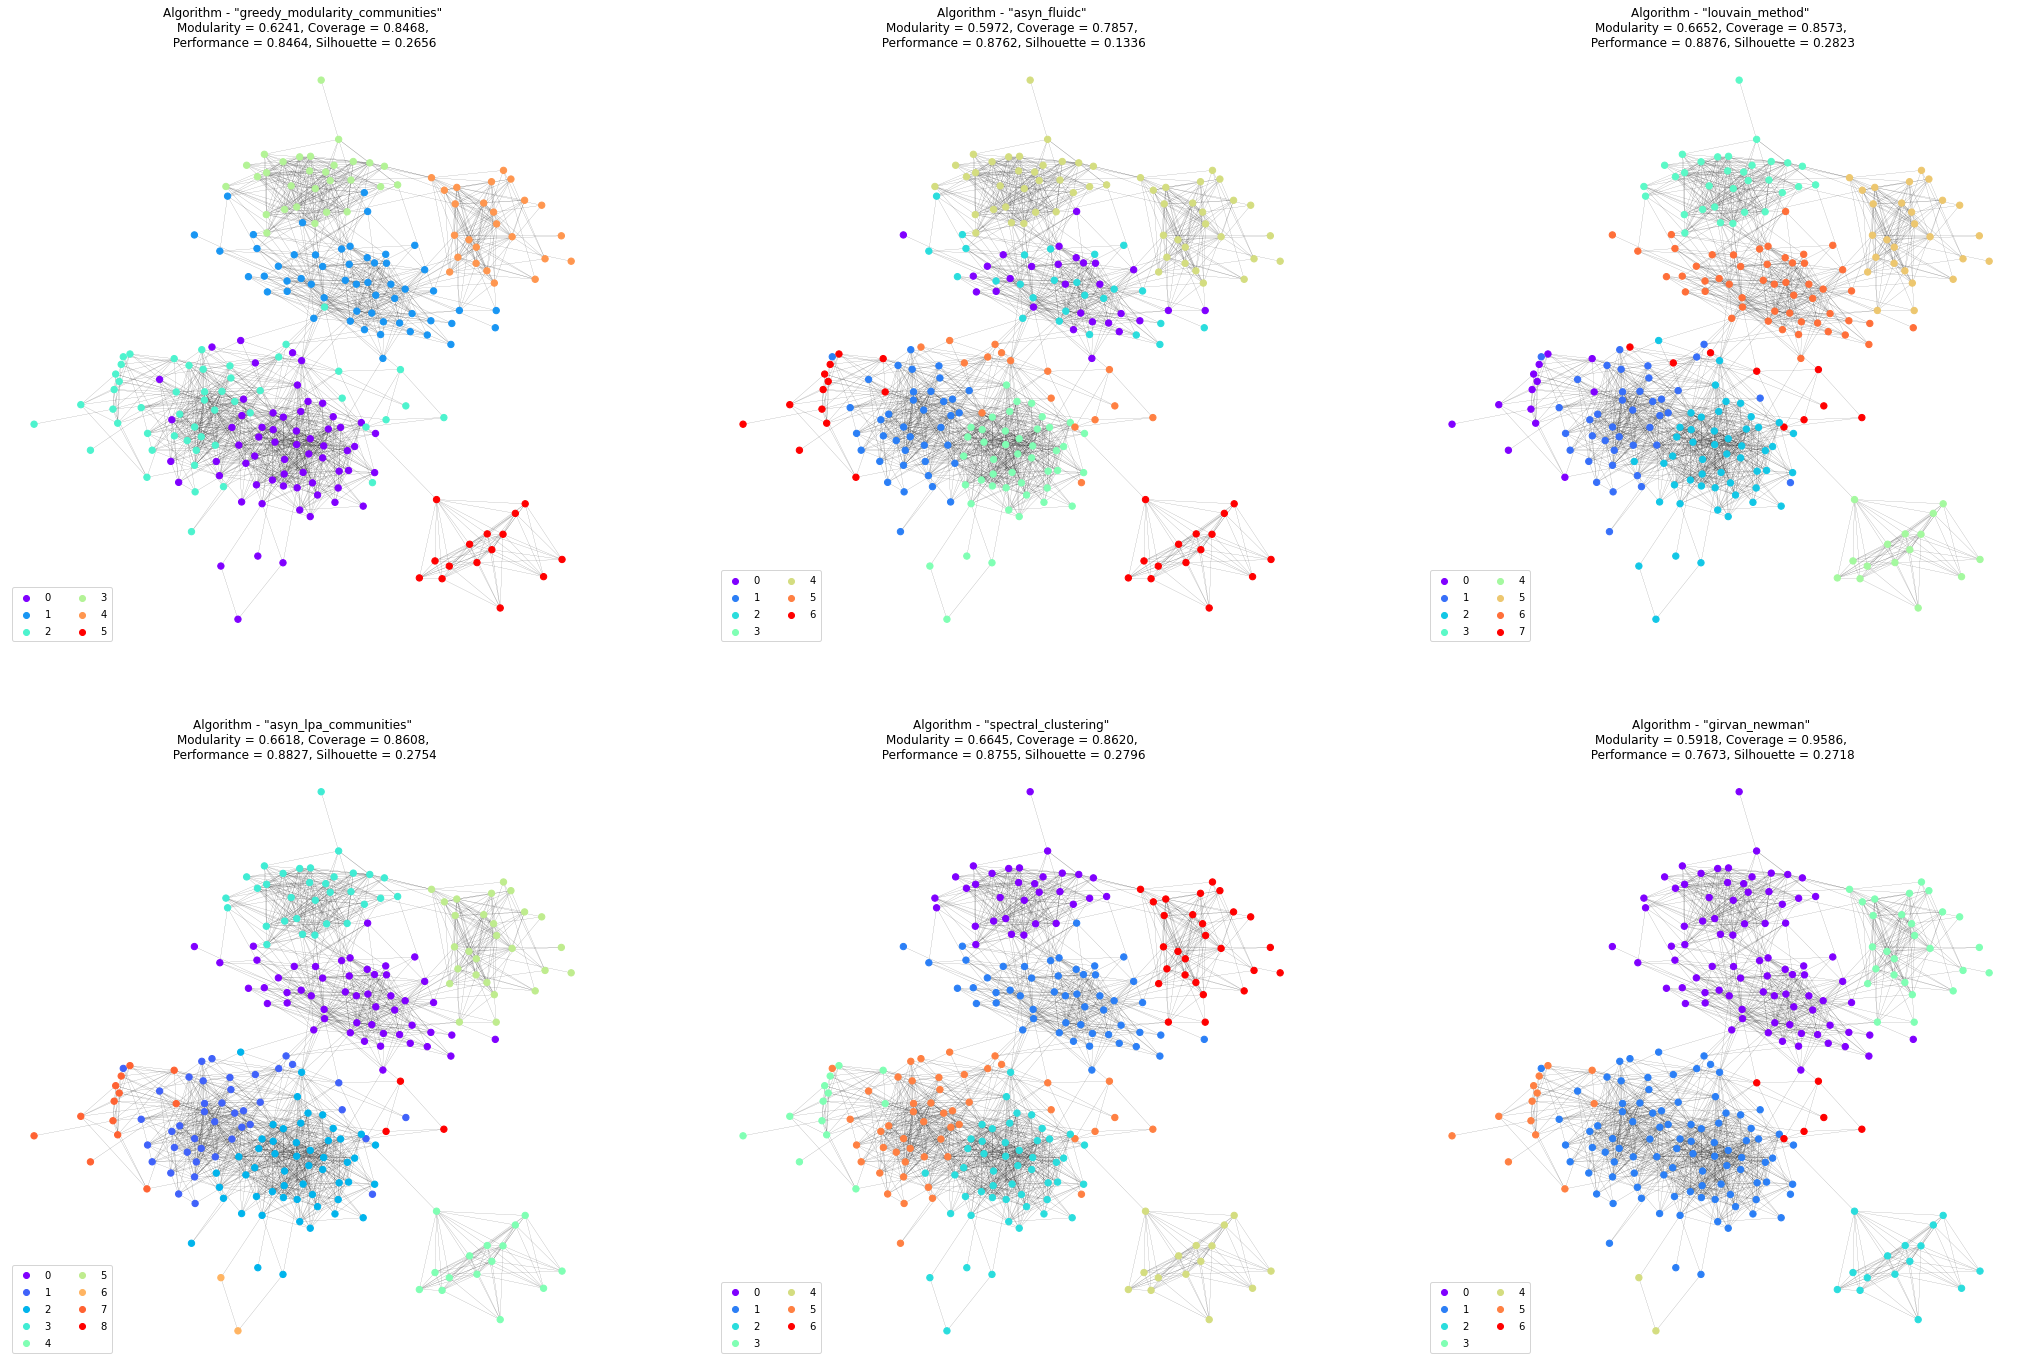

In [ ]:
k = 7
com_algs = {'greedy_modularity_communities':gmc,
            'asyn_fluidc':lambda x: fc(x, k),
            'louvain_method':lm,
            'asyn_lpa_communities':alp,
            'spectral_clustering': lambda x: sc(x, k, k-1),
            'girvan_newman':lambda x: gn(x, k)} 
scores = show_graph_communities(lc, com_algs)

In [ ]:
score_df = pd.DataFrame().from_dict(scores).T.rename_axis('Algorithm')
score_df['Sum'] = score_df.sum(axis=1)/len(score_df.columns)
score_df.sort_values(by=['Sum'], ascending=False)

,modularity,coverage,performance,silhouette,Sum
Algorithm,,,,,
louvain_method,0.665199,0.857309,0.887636,0.282339,0.673121
spectral_clustering,0.664529,0.861969,0.875474,0.279579,0.670388
asyn_lpa_communities,0.661780,0.860804,0.882672,0.275363,0.670155
girvan_newman,0.591793,0.958649,0.767259,0.271792,0.647373
greedy_modularity_communities,0.624127,0.846826,0.846364,0.265620,0.645734
asyn_fluidc,0.597206,0.785673,0.876219,0.133632,0.598182
